
# Introduction to Data Science
# Mini Project 1

### Abraham Pineda 
#### ID: 73993

---

**Introduction**

For this project we have to extract information from the YELP website and suggest the top 5 "breakfast and brunch" restaurants in "Helsinki" area. In order for us to select the best restaurants we have to extract the information and filter it with the following requirements: 
* should accept credit card payment
* with the average price between 8-25€
* have at least 5 reviews
* open at the weekends

In the following document we will demonstrate how the information was extracted, analyzed and plotted using *Python*.

## YELP filtering

We have two options to extract the data from the YELP website:
1. Extract all the information without inner filters.
2. Extract information using inner filters.

Because we want to facilitate the process of extracting the data from the website (and it is not forbidden from the requirements of the project) we will use option #2.

We will use some of the available filters that are in YELP and helps us ease the filtering process, these filters are:
* Breakfast and Brunch restaurants only
* restaurants which accept credit card
* select address near city center as a point of reference
* restaurants which cover the price range required

![alt text](Yelp Filters.PNG "YELP Filters")

And now we proceed with scraping the data.


# Code

## Python Libraries

We will be using the following libraries for this mini project:

In [196]:
## all imports
from IPython.display import HTML
import numpy as np
import urllib2
import bs4 #this is beautiful soup
import time
import operator
import socket
import cPickle
import re # regular expressions
import nbconvert

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from secret import *

We create the class RestaurantInfo in which we will add the information of each restaurant that we acquire

In [121]:
#we create a class to save all the information of each restaurant
class RestaurantInfo:
    def __init__(self, name, stars, ratings, price, distance):
        self.name = name
        self.stars = stars
        self.ratings = ratings
        self.price = price
        self.distance = distance

We obtain the url from the YELP website with its filters included, we read it and use *Beautiful Soup* to parse the html code

In [5]:
# Fixed url for yelp website with filters
url = 'https://www.yelp.com/search?start=0&attrs=RestaurantsPriceRange2.2,RestaurantsPriceRange2.1,BusinessAcceptsCreditCards,GoodForMeal.breakfast,GoodForMeal.brunch&find_near=helsingin-p%C3%A4%C3%A4rautatieasema-helsinki'
# read the website
source = urllib2.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source, "lxml")

We scrap the number of restaurants in total

In [204]:
#we look for the number of restaurants in total
restaurant_count_string = bs_tree.find('span', {'class': 'pagination-results-window'}).contents[0]
restaurant_count_string = restaurant_count_string.split()[-1]

print("Search yielded %s restaurants." % (restaurant_count_string))

restaurant_count_digits = [int(d) for d in restaurant_count_string if d.isdigit()]
restaurant_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(restaurant_count_digits[::-1], range(len(restaurant_count_digits)))])

Search yielded 17 restaurants.


Now we do a numerous of steps here:
* get and calculate number of pages
* go through each restaurant
* filter out restaurants that do not meet the criteria required
* create objects of type RestaurantInfo to insert the restaurant information one by one
* insert all objects into a list of restaurants

In [207]:
#we get the number of pages to search for
num_pages = int(np.ceil(restaurant_count/10.0))

base_url = 'https://www.yelp.com'
restaurant_list = []

for i in range(num_pages):
    url = 'https://www.yelp.com/search?start=' + str(i*10) + '&attrs=RestaurantsPriceRange2.2,RestaurantsPriceRange2.1,BusinessAcceptsCreditCards,GoodForMeal.breakfast,GoodForMeal.brunch&find_near=helsingin-p%C3%A4%C3%A4rautatieasema-helsinki'
    html_page = urllib2.urlopen(url).read() 
    yelp = bs4.BeautifulSoup(html_page)
    
    #search results one by one
    for rst in yelp.findAll('li', {'class': u'regular-search-result'}):
        
        weekend = True
        rst_ratings = rst.find('span', {'class': u'review-count rating-qualifier'}).get_text().split()[0] 
        
        #search for a min of 5 ratings
        if int(rst_ratings) >= 5:
            
            #Get url of rst page for weekend availability
            rst_url = base_url + rst.find('a', {'class': u'biz-name'})['href'].split()[0]
            rst_page = urllib2.urlopen(rst_url).read()
            rst_tree = bs4.BeautifulSoup(rst_page)
            #extract hours table 
            try:
                rst_days = rst_tree.find('table', {'class': u'table table-simple hours-table'})
                rst_days = rst_days.contents[1]
            
                #search for weekend only
                for day in rst_days.findAll('tr')[5:]:
                    if weekend == True:
                        if (day.find('td').get_text().encode('utf-8').strip()) == 'Closed':
                            weekend = False
            #when there is no hours table, the rst would be ommited
            except:
                weekend = False
                
            #if it has weekend open, then extract the rest of the data    
            if weekend == True:
                rst_name = rst.find('a', {'class': u'biz-name'}).get_text().encode('utf-8').strip()
                rst_stars = rst.find('div', {'class': u'i-stars'})['title'].split()[0]
                rst_price = rst.find('span', {'class': u'business-attribute price-range'}).get_text().encode('utf-8').strip()
                rst_distance = rst.find('small').get_text().encode('utf-8').split()[0]
                rst_info = RestaurantInfo(rst_name, rst_stars, rst_ratings, rst_price, rst_distance)
                

                #save info on list of objets(RestaurantInfo)
                restaurant_list.append(rst_info)
                

Now we extract the information from each restaurant and display it as a table.

In [262]:
## create pandas data frame with stars count
rst_stars = [rst.stars for rst in restaurant_list]
rst_ratings = [rst.ratings for rst in restaurant_list]
rst_distance = rst_distance = [rst.distance for rst in restaurant_list]
rst_price = [rst.price for rst in restaurant_list]

restaurants = pd.DataFrame(data=[rst_stars, rst_ratings, rst_distance, rst_price]).transpose()

restaurants.columns = ['stars', 'ratings', 'distance', 'price']

## also create a list with all restaurant names
rst_names = [rst.name for rst in restaurant_list]

restaurants.set_index([rst_names], inplace=True)

## Scraped data:
After scraping and filtering the data from YELP, we got the following restaurants that meet the criteria we want:

In [211]:
display(restaurants)

,stars,ratings,distance,price
Café Lasipalatsi,4.0,19,0.2,€€
Café Engel,4.0,27,0.4,€€
Tin Tin Tango,4.0,27,0.8,€€
Deli Cafe Maya,4.0,11,0.6,€
Cafe Talo,4.0,16,0.7,€€
Cargo,4.5,8,0.8,€€
SIS. Deli & Cafe,4.0,5,0.7,€€
Factory St. Gallery,4.0,5,0.9,€
Bergga,3.5,9,1.0,€


## Plots
Now that we have collected the information we need, we have to analyze it in order to make a final decision on which restaurants are the top 5.

We can make different plots such as to compare ratings, # of reviews, price and distance.

                    stars
Café Lasipalatsi      4.0
Café Engel            4.0
Tin Tin Tango         4.0
Deli Cafe Maya        4.0
Cafe Talo             4.0
Cargo                 4.5
SIS. Deli & Cafe      4.0
Factory St. Gallery   4.0
Bergga                3.5


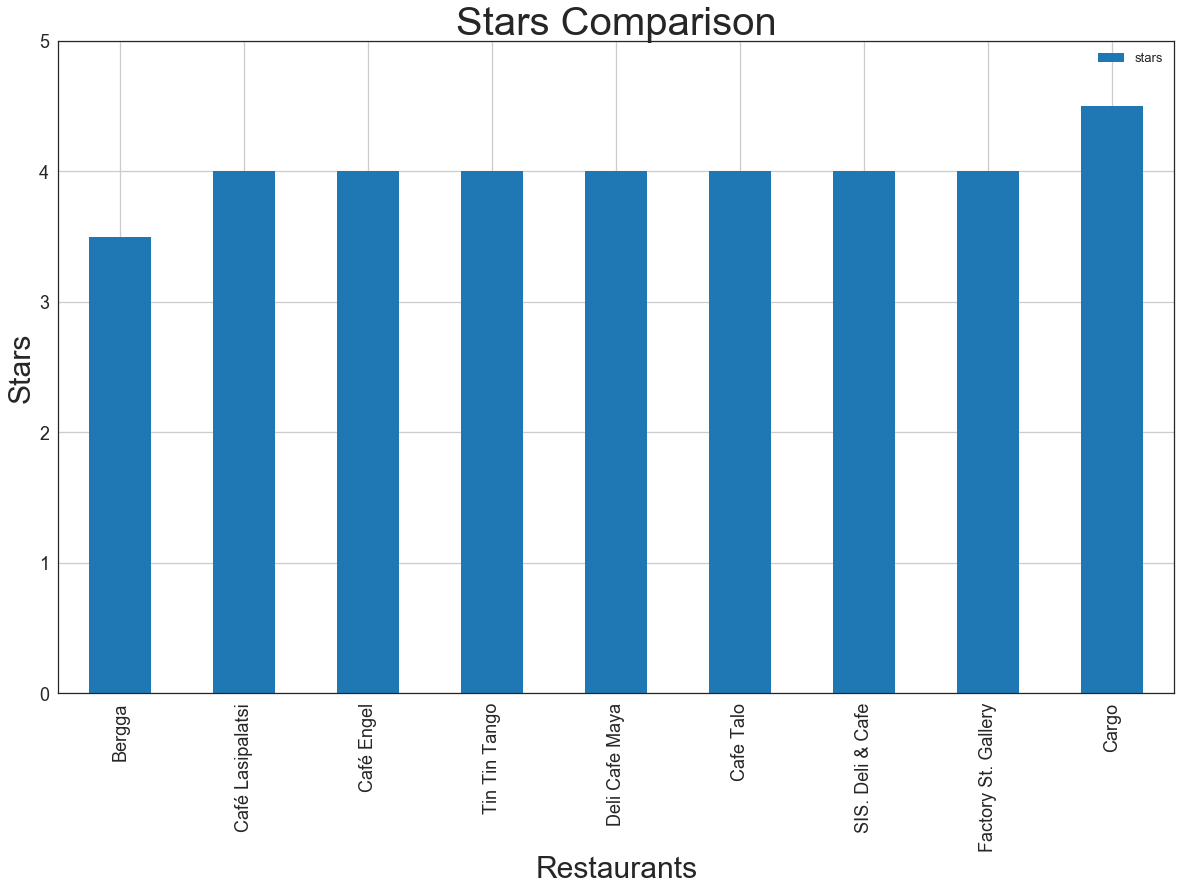

In [190]:
## create pandas data frame with stars count
rst_stars = [rst.stars for rst in restaurant_list]

stars = pd.DataFrame(data=[rst_stars]).transpose()

stars.columns = ['stars']

## also create a list with all restaurant names
rst_names = [rst.name for rst in restaurant_list]

stars.set_index([rst_names], inplace=True)
print stars.head(9)

## create a bar plot with the data
## notice that we are using the data frame itself and call its plot function
stars = stars.astype(float)
stars = stars.sort_values('stars', ascending=True)
stars.plot(kind='bar', fontsize=18)

## set the title to Stars Comparison
plt.title('Stars Comparison', fontsize=40)

## set the x label
plt.xlabel('Restaurants', fontsize=30)

## set the y label
plt.ylabel('Stars', fontsize=30)

## set the y axis
plt.ylim([0,5])

#plt.xticks(np.arange(0.5))

plt.grid()

                    stars ratings
Café Lasipalatsi      4.0      19
Café Engel            4.0      27
Tin Tin Tango         4.0      27
Deli Cafe Maya        4.0      11
Cafe Talo             4.0      16
Cargo                 4.5       8
SIS. Deli & Cafe      4.0       5
Factory St. Gallery   4.0       5
Bergga                3.5       9


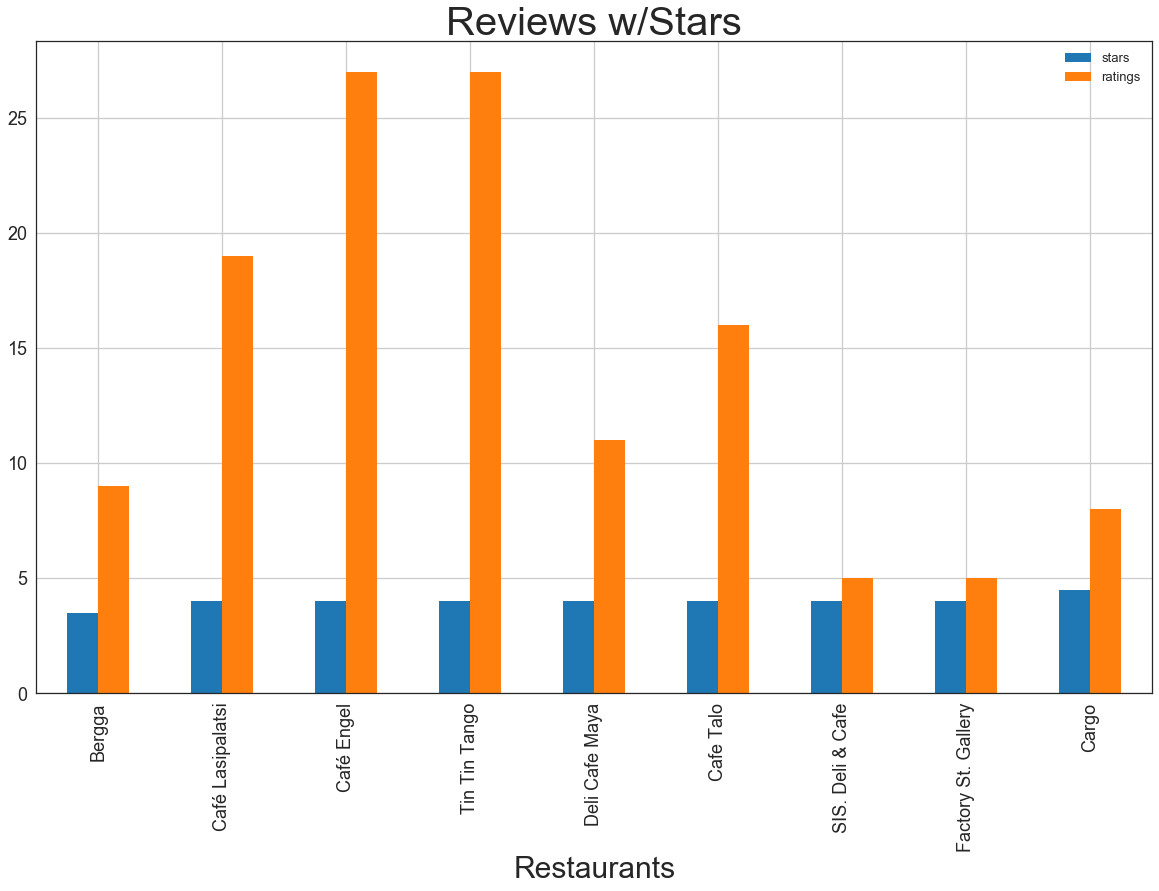

In [187]:
## create pandas data frame with stars count
rst_stars = [rst.stars for rst in restaurant_list]
rst_ratings = [rst.ratings for rst in restaurant_list]

reviews = pd.DataFrame(data=[rst_stars, rst_ratings]).transpose()

reviews.columns = ['stars', 'ratings']

## also create a list with all restaurant names
rst_names = [rst.name for rst in restaurant_list]

reviews.set_index([rst_names], inplace=True)
print reviews.head(9)

## create a bar plot with the data
## notice that we are using the data frame itself and call its plot function
reviews = reviews.astype(float)
reviews = reviews.sort_values('stars', ascending=True)
reviews.plot(kind='bar', fontsize=18)




## set the title to Stars Comparison
plt.title('Reviews w/Stars', fontsize=40)

## set the x label
plt.xlabel('Restaurants', fontsize=30)

##set size of plot
plt.rcParams["figure.figsize"] = [20,12]

plt.grid()

## set the y axis
#plt.ylim([0,5])


### Ratings and Stars
Even though we now know which restaurants have the best ratings, we have to take in account that some of them may have less reviews than others. 

So we create a weighted rating value, in which we take the maximum number of review and the maximum number of stars given so we can make them be the maximum value to get for all restaurants.



In [227]:
print "Maximum number of stars and ratings gotten:"

reviews.max()

Maximum number of stars and ratings gotten:


stars       4.5
ratings    27.0
dtype: float64

### Weighted Rating
We will give a weight of 3 to ratings and a weight of 7 to stars, so the maximum score will be 10. Restaurants closer to this number will be selected for top 5.

In [284]:
max_stars = reviews.stars.max()
max_ratings = reviews.ratings.max()
max_range = reviews.stars.count()

rst_stars_w=[]
rst_ratings_w=[]
rst_reviews_w=[]

for star in rst_stars:
    rst_stars_w.append(float(star) / max_stars)
for rating in rst_ratings:
    rst_ratings_w.append(float(rating) / max_ratings)
    

for i in range(max_range):
    rst_reviews_w.append((rst_stars_w[i]*7) + (rst_ratings_w[i]*3))


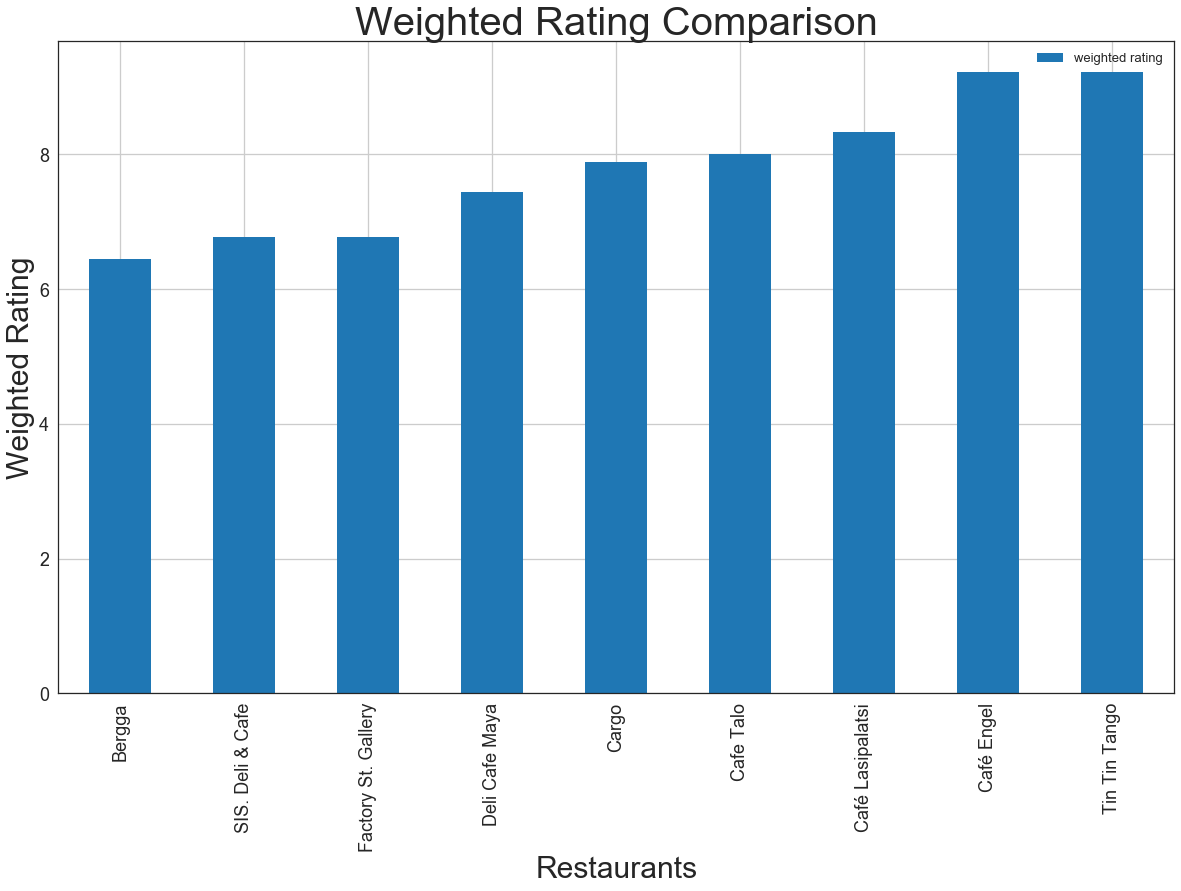

In [285]:
## create pandas data frame with weighted ratings
review_w = pd.DataFrame(data=[rst_reviews_w]).transpose()

review_w.columns = ['weighted rating']

## also create a list with all restaurant names
rst_names = [rst.name for rst in restaurant_list]

review_w.set_index([rst_names], inplace=True)

## create a bar plot with the data
## notice that we are using the data frame itself and call its plot function
review_w = review_w.astype(float)
review_w = review_w.sort_values('weighted rating', ascending=True)
review_w.plot(kind='bar', fontsize=18)

## set the title to Stars Comparison
plt.title('Weighted Rating Comparison', fontsize=40)

## set the x label
plt.xlabel('Restaurants', fontsize=30)

## set the y label
plt.ylabel('Weighted Rating', fontsize=30)

##set size of plot
plt.rcParams["figure.figsize"] = [20,12]

#plt.xticks(np.arange(0.5))

plt.grid()

## Conclusion
The top 5 restaurants that we choose to be considered the best restaurants to go to (with analyzed data to confirm it) will be:
1. Tin Tin Tango
2. Café Engel 
3. Café Lasipalatsi
4. Cafe Talo
5. Cargo

### Comments
I planned to do a comparison with distance and price too, but I did not have enough time to do it. But it is to be implemented in the future.